Data: [Bird Migration Dataset (Data Visualization / EDA)](https://www.kaggle.com/datasets/sahirmaharajj/bird-migration-dataset-data-visualization-eda) <br>
LightGBM, SVC

In [1]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import geohash2
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
data_path = '/hdd/data/adp_data/bird_migration_data.csv'

df = pd.read_csv(data_path, index_col = 'Bird_ID')
df.head()

,Species,Region,Habitat,Weather_Condition,Migration_Reason,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Flight_Distance_km,Flight_Duration_hours,Average_Speed_kmph,Max_Altitude_m,Min_Altitude_m,Temperature_C,Wind_Speed_kmph,Humidity_%,Pressure_hPa,Visibility_km,Nesting_Success,Tag_Battery_Level_%,Signal_Strength_dB,Migration_Start_Month,Migration_End_Month,Rest_Stops,Predator_Sightings,Tag_Type,Migrated_in_Flock,Flock_Size,Food_Supply_Level,Tracking_Quality,Migration_Interrupted,Interrupted_Reason,Tagged_By,Tag_Weight_g,Migration_Success,Recovery_Location_Known,Recovery_Time_days,Observation_Counts,Observation_Quality
Bird_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B1000,Warbler,South America,Grassland,Stormy,Feeding,11.906566,-169.378251,30.377647,-21.366879,1753.79,49.5,47.82,5280,285,-2.2,9.1,43,1030.3,1.5,No,45,-64.9,Jan,Apr,3,6,Radio,Yes,264,Low,Excellent,Yes,Storm,Researcher_A,27.0,Failed,No,102,56,Low
B1001,Stork,North America,Grassland,Stormy,Breeding,62.301546,-111.475069,39.921092,47.963436,3263.05,46.1,48.41,3166,896,6.6,59.6,50,1006.6,1.5,Yes,58,-68.0,Apr,Dec,2,3,Radio,Yes,212,High,Good,Yes,Injury,Researcher_C,14.2,Successful,Yes,118,61,Low
B1002,Hawk,South America,Mountain,Stormy,Avoid Predators,87.861164,-78.727327,66.990980,19.448466,2871.65,30.2,57.36,5880,444,31.0,12.3,88,969.6,1.5,Yes,82,-71.9,May,Nov,2,3,GPS,Yes,340,High,Fair,No,Lost Signal,Researcher_B,16.1,Failed,No,41,71,High
B1003,Warbler,South America,Urban,Stormy,Climate Change,35.770590,153.104341,-49.003145,-157.868744,2317.38,58.7,55.38,1120,806,11.0,16.4,19,970.0,17.5,No,86,-70.2,Jan,Nov,8,5,GPS,No,484,Medium,Good,Yes,Lost Signal,Researcher_C,24.4,Successful,No,15,68,Low
B1004,Crane,Europe,Urban,Windy,Avoid Predators,-21.611614,106.674824,11.681051,-115.022863,3077.38,56.9,53.92,7921,676,13.5,31.7,64,972.2,14.2,No,47,-50.5,Oct,Oct,11,3,GPS,No,184,Low,Good,No,NaN,Researcher_B,25.8,Failed,Yes,73,67,Moderate


In [3]:
def LatLon_scatter(df, latitude_col, longitude_col, group_col, s):
    plt.figure(figsize = (10, 6))
    scatter = plt.scatter(
        df[longitude_col], df[latitude_col],
        c = df[group_col], cmap = 'tab20', s = s
    )
    plt.colorbar(scatter, label = 'Group')
    plt.title(f'Group by {group_col}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


추출된 클러스터 수: 64 (noise 포함)


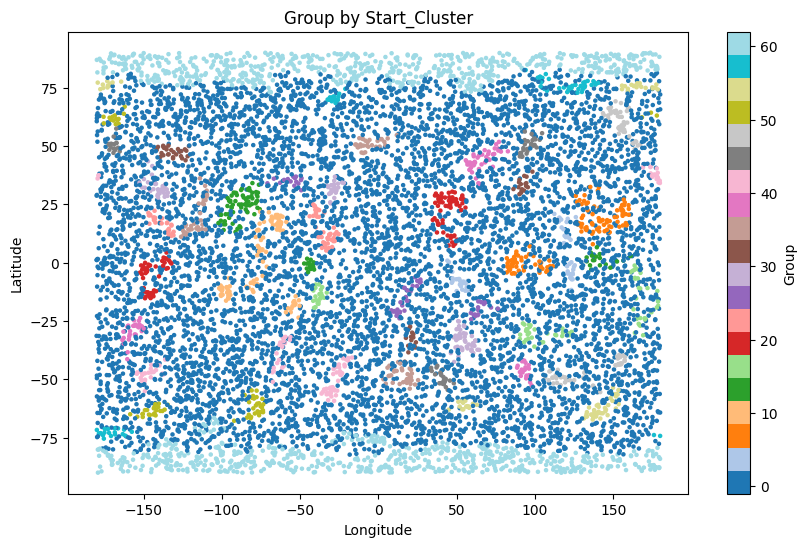

In [4]:
start_cols = ['Start_Latitude', 'Start_Longitude']
coords = df[start_cols].values

clusterer = hdbscan.HDBSCAN(min_cluster_size = 15, metric = 'haversine')
coords_rad = np.radians(coords)

df['Start_Cluster'] = clusterer.fit_predict(coords_rad)

n_clusters = df['Start_Cluster'].nunique()
print(f'추출된 클러스터 수: {n_clusters} (noise 포함)')

LatLon_scatter(df, 'Start_Latitude', 'Start_Longitude', 'Start_Cluster', s = 5)

변수로 사용하기에는 noise가 너무 많은 것같음. 64개의 cluster도 dummy 변수로 나타내기엔 많음. 위경도 기준으로 그룹핑 진행

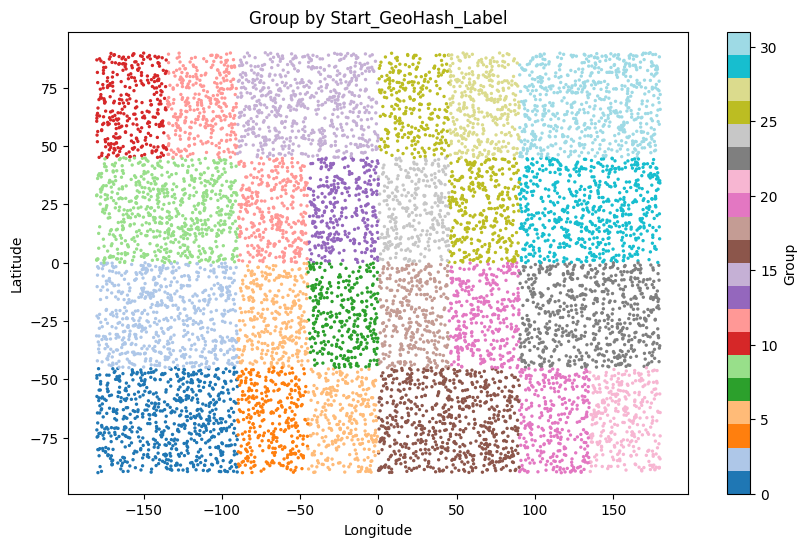

In [5]:
df['Start_GeoHash'] = df.apply(
    lambda row: geohash2.encode(row['Start_Latitude'], row['Start_Longitude'], precision = 1),
    axis = 1
)
df['Start_GeoHash_Label'] = df['Start_GeoHash'].astype('category').cat.codes
LatLon_scatter(df, 'Start_Latitude', 'Start_Longitude', 'Start_GeoHash_Label', 2)

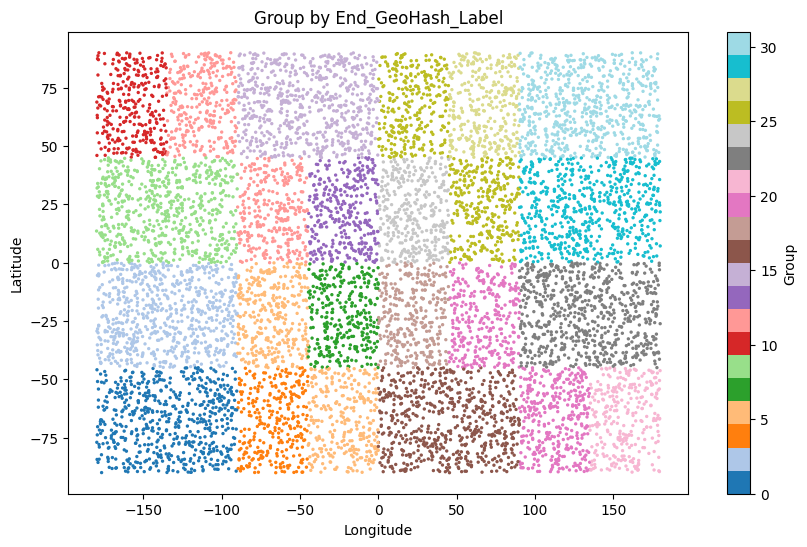

In [6]:
df['End_GeoHash'] = df.apply(
    lambda row: geohash2.encode(row['End_Latitude'], row['End_Longitude'], precision = 1),
    axis = 1
)
df['End_GeoHash_Label'] = df['End_GeoHash'].astype('category').cat.codes
LatLon_scatter(df, 'End_Latitude', 'End_Longitude', 'End_GeoHash_Label', 2)

In [7]:
df.groupby('Migration_Interrupted')['Interrupted_Reason'].value_counts().unstack(fill_value = 0)

Interrupted_Reason,Injury,Lost Signal,Predator,Storm
Migration_Interrupted,,,,
No,1012,992,992,993
Yes,1011,951,1002,1066


In [8]:
drop_cols = ['Tagged_By', 'Start_Cluster', 'Start_GeoHash_Label', 'End_GeoHash_Label', 'Migration_Interrupted']
df = df.drop(columns = drop_cols)

df_lgb = df.copy()

df_lgb['Migration_Success'] = df_lgb['Migration_Success'].map({'Successful': 1, 'Failed': 0})

df_lgb['Interrupted_Reason'] = df_lgb['Interrupted_Reason'].fillna('Uninterrupted')

df_lgb['Geo_Distance_km'] = df_lgb.apply(
    lambda row: geodesic((row['Start_Latitude'], row['Start_Longitude']),
                         (row['End_Latitude'], row['End_Longitude'])).km,
    axis = 1
)

cat_cols = df_lgb.select_dtypes(include = 'object').columns.tolist()
le = LabelEncoder()
for col in cat_cols:
    df_lgb[col] = le.fit_transform(df_lgb[col])

df_lgb.head()

,Species,Region,Habitat,Weather_Condition,Migration_Reason,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Flight_Distance_km,Flight_Duration_hours,Average_Speed_kmph,Max_Altitude_m,Min_Altitude_m,Temperature_C,Wind_Speed_kmph,Humidity_%,Pressure_hPa,Visibility_km,Nesting_Success,Tag_Battery_Level_%,Signal_Strength_dB,Migration_Start_Month,Migration_End_Month,Rest_Stops,Predator_Sightings,Tag_Type,Migrated_in_Flock,Flock_Size,Food_Supply_Level,Tracking_Quality,Interrupted_Reason,Tag_Weight_g,Migration_Success,Recovery_Location_Known,Recovery_Time_days,Observation_Counts,Observation_Quality,Start_GeoHash,End_GeoHash,Geo_Distance_km
Bird_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B1000,6,5,2,3,3,11.906566,-169.378251,30.377647,-21.366879,1753.79,49.5,47.82,5280,285,-2.2,9.1,43,1030.3,1.5,0,45,-64.9,2,0,3,6,1,1,264,1,0,3,27.0,0,0,102,56,1,8,13,14215.984349
B1001,4,4,2,3,1,62.301546,-111.475069,39.921092,47.963436,3263.05,46.1,48.41,3166,896,6.6,59.6,50,1006.6,1.5,1,58,-68.0,0,1,2,3,1,1,212,0,2,0,14.2,1,1,118,61,1,11,25,8523.779008
B1002,3,5,3,3,0,87.861164,-78.727327,66.990980,19.448466,2871.65,30.2,57.36,5880,444,31.0,12.3,88,969.6,1.5,1,82,-71.9,4,5,2,3,0,1,340,0,1,1,16.1,0,0,41,71,0,14,26,2612.730042
B1003,6,5,4,3,2,35.770590,153.104341,-49.003145,-157.868744,2317.38,58.7,55.38,1120,806,11.0,16.4,19,970.0,17.5,0,86,-70.2,2,5,8,5,0,0,484,2,2,1,24.4,1,0,15,68,1,29,0,10566.888166
B1004,0,3,4,4,0,-21.611614,106.674824,11.681051,-115.022863,3077.38,56.9,53.92,7921,676,13.5,31.7,64,972.2,14.2,0,47,-50.5,6,6,11,3,0,0,184,1,2,4,25.8,0,1,73,67,2,22,9,15465.480249


In [9]:
target = 'Migration_Success'
X = df_lgb.drop(columns = [target])
y = df_lgb[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 526, stratify = y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8000, 40) (2000, 40)
(8000,) (2000,)


In [10]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature = cat_cols)
valid_data = lgb.Dataset(X_test, label = y_test, categorical_feature = cat_cols)

params = {
    'objective': 'binary',
    'metric':  'binary_logloss',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 526,
}

model = lgb.train(
    params,
    train_data,
    valid_sets = [train_data, valid_data],
    valid_names = ['train', 'valid'],
    num_boost_round = 1000,
    callbacks = [
        early_stopping(stopping_rounds = 50),
        log_evaluation(100)
    ]
)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_binary))
print('\nClassification Report:\n', classification_report(y_test, y_pred_binary))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_binary))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.688633	valid's binary_logloss: 0.692983
Accuracy: 0.502

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.06      0.10       981
           1       0.51      0.93      0.66      1019

    accuracy                           0.50      2000
   macro avg       0.47      0.49      0.38      2000
weighted avg       0.48      0.50      0.38      2000


Confusion Matrix:
 [[ 58 923]
 [ 73 946]]


가상 데이터이므로 결과에 대한 해석 생략

In [11]:
df_pca = df.copy()
y = df['Migration_Success']
df_pca = df_pca.drop(columns = ['Migration_Success'])

cat_cols = df_pca.select_dtypes(include = 'object').columns.tolist()

ohe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
X_cat = ohe.fit_transform(df_pca[cat_cols])

ohe_cols = ohe.get_feature_names_out(cat_cols)

X_cat_df = pd.DataFrame(X_cat, columns = ohe_cols, index = df.index)

In [12]:
X_num = df_pca.drop(columns = cat_cols)
X_all = pd.concat([X_num, X_cat_df], axis = 1)

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_scaled)

print(f'PCA 결과 shape: {X_pca.shape}')
print(f'설명된 분산 비율 합계: {pca.explained_variance_ratio_.sum():.4f}')

PCA 결과 shape: (10000, 124)
설명된 분산 비율 합계: 0.9539


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 526, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8000, 124) (2000, 124)
(8000,) (2000,)


In [16]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  55.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  55.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  56.6s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  56.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  57.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  57.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  57.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  58.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  58.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  58.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  58.8s
[CV] END ......................C=0.1, gamma=0.01

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=2)

In [17]:
print('Best Parameters:', grid.best_params_)
print('Best CV Score:', grid.best_score_)

y_pred = grid.predict(X_test)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV Score: 0.51775
Test Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

      Failed       0.50      0.50      0.50       981
  Successful       0.52      0.52      0.52      1019

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000


Confusion Matrix:
[[489 492]
 [488 531]]
